# Evaluation

We are now evaluating our best models. Our best models from the model optimization phase are K-Means and Hierarchical Clustering.

In [39]:
import numpy as np
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
)
from sklearn.utils import resample
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


df = pd.read_csv("../data/processed/X_umap.csv")
df_standard_scaled = pd.read_csv("../data/processed/X_standard_scaled.csv")
df_unscaled = pd.read_csv("../data/interim/weather_per_country.csv")


def kmean_clustering_func(data):
    return KMeans(n_clusters=4, random_state=42).fit_predict(data)


def hierarchical_clustering_func(data):
    return AgglomerativeClustering(linkage="average", n_clusters=4).fit_predict(data)


cluster_function = {
    "KMeans": kmean_clustering_func,
    "Hierarchical": hierarchical_clustering_func,
}

labels = {
    "KMeans": cluster_function["KMeans"](df),
    "Hierarchical": cluster_function["Hierarchical"](df),
}

In [25]:
def comprehensive_cluster_evaluation(data, labels, external_labels=None):
    """Comprehensive evaluation using multiple metrics"""

    print("COMPREHENSIVE CLUSTER EVALUATION")
    print("=" * 33)

    # Basic cluster information
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = np.sum(labels == -1) if -1 in unique_labels else 0

    print(f"Clusters found: {n_clusters}")
    print(f"Noise points: {n_noise}")
    print(f"Total samples: {len(labels)}")

    results = {"n_clusters": n_clusters, "n_noise": n_noise}

    # Internal metrics (skip if insufficient clusters)
    if n_clusters > 1:
        print(f"\nINTERNAL METRICS:")
        print("-" * 16)

        # For DBSCAN, exclude noise points from evaluation
        if -1 in unique_labels:
            non_noise_mask = labels != -1
            eval_data = data[non_noise_mask]
            eval_labels = labels[non_noise_mask]
        else:
            eval_data = data
            eval_labels = labels

        # Calculate internal metrics
        silhouette = silhouette_score(eval_data, eval_labels)
        davies_bouldin = davies_bouldin_score(eval_data, eval_labels)
        calinski_harabasz = calinski_harabasz_score(eval_data, eval_labels)

        print(f"Silhouette Score: {silhouette:.3f} (higher = better)")
        print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (lower = better)")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.1f} (higher = better)")

        results.update(
            {
                "silhouette": silhouette,
                "davies_bouldin": davies_bouldin,
                "calinski_harabasz": calinski_harabasz,
            }
        )

        # Interpret results
        sil_quality = (
            "Excellent"
            if silhouette > 0.7
            else "Good"
            if silhouette > 0.5
            else "Fair"
            if silhouette > 0.25
            else "Poor"
        )
        print(f"Overall quality assessment: {sil_quality}")

    else:
        print(f"\n⚠️ Insufficient clusters for internal metrics")
        results.update(
            {"silhouette": -1, "davies_bouldin": np.inf, "calinski_harabasz": 0}
        )

    # External metrics (if external labels provided)
    if external_labels is not None and n_clusters > 1:
        print(f"\nEXTERNAL METRICS:")
        print("-" * 16)

        ari = adjusted_rand_score(external_labels, labels)
        nmi = normalized_mutual_info_score(external_labels, labels)
        v_measure = v_measure_score(external_labels, labels)

        print(f"Adjusted Rand Index: {ari:.3f} (higher = better)")
        print(f"Normalized Mutual Information: {nmi:.3f} (higher = better)")
        print(f"V-Measure: {v_measure:.3f} (higher = better)")

        results.update({"ari": ari, "nmi": nmi, "v_measure": v_measure})

        # Interpret external validation
        ext_quality = "Strong" if ari > 0.7 else "Moderate" if ari > 0.4 else "Weak"
        print(f"External validation: {ext_quality} agreement")

    return results


def stability_evaluation(data, clustering_func, n_trials=20):
    """Evaluate clustering stability via bootstrap"""

    print(f"\nSTABILITY EVALUATION ({n_trials} trials)")
    print("=" * 30)

    stability_scores = []

    # Generate reference clustering
    reference_labels = clustering_func(data)

    for trial in range(n_trials):
        # Bootstrap sample
        bootstrap_data = resample(data, random_state=trial)
        bootstrap_labels = clustering_func(bootstrap_data)

        # Calculate stability (simplified - assumes same data size)
        if len(bootstrap_labels) == len(reference_labels):
            # Find the indices of the bootstrap samples in the original data
            bootstrap_indices = (
                bootstrap_data.index
                if hasattr(bootstrap_data, "index")
                else np.arange(len(bootstrap_data))
            )
            # Align reference_labels to the bootstrap sample
            aligned_reference_labels = reference_labels[bootstrap_indices]
            stability = adjusted_rand_score(aligned_reference_labels, bootstrap_labels)
            stability_scores.append(stability)

    if stability_scores:
        mean_stability = np.mean(stability_scores)
        std_stability = np.std(stability_scores)

        print(f"Mean stability (ARI): {mean_stability:.3f} ± {std_stability:.3f}")

        if mean_stability > 0.8:
            stability_assessment = "✅ Highly stable"
        elif mean_stability > 0.6:
            stability_assessment = "⚡ Moderately stable"
        else:
            stability_assessment = "❌ Unstable"

        print(f"Stability assessment: {stability_assessment}")

        return {
            "mean_stability": mean_stability,
            "std_stability": std_stability,
            "assessment": stability_assessment,
        }
    else:
        print("❌ Stability evaluation failed")
        return None


kmean_eval_results = comprehensive_cluster_evaluation(df, labels["KMeans"])
kmean_stability_results = stability_evaluation(df, cluster_function["KMeans"])

hierarchical_eval_results = comprehensive_cluster_evaluation(df, labels["Hierarchical"])
hierarchical_stability_results = stability_evaluation(
    df, cluster_function["Hierarchical"]
)

COMPREHENSIVE CLUSTER EVALUATION
Clusters found: 4
Noise points: 0
Total samples: 185

INTERNAL METRICS:
----------------
Silhouette Score: 0.563 (higher = better)
Davies-Bouldin Index: 0.650 (lower = better)
Calinski-Harabasz Index: 748.0 (higher = better)
Overall quality assessment: Good

STABILITY EVALUATION (20 trials)
Mean stability (ARI): 0.914 ± 0.060
Stability assessment: ✅ Highly stable
COMPREHENSIVE CLUSTER EVALUATION
Clusters found: 4
Noise points: 0
Total samples: 185

INTERNAL METRICS:
----------------
Silhouette Score: 0.565 (higher = better)
Davies-Bouldin Index: 0.676 (lower = better)
Calinski-Harabasz Index: 724.0 (higher = better)
Overall quality assessment: Good

STABILITY EVALUATION (20 trials)
Mean stability (ARI): 0.809 ± 0.095
Stability assessment: ✅ Highly stable


CLUSTER VISUALIZATION OVERVIEW
Dataset: 185 observations, 11 features
Clusters: 4 discovered


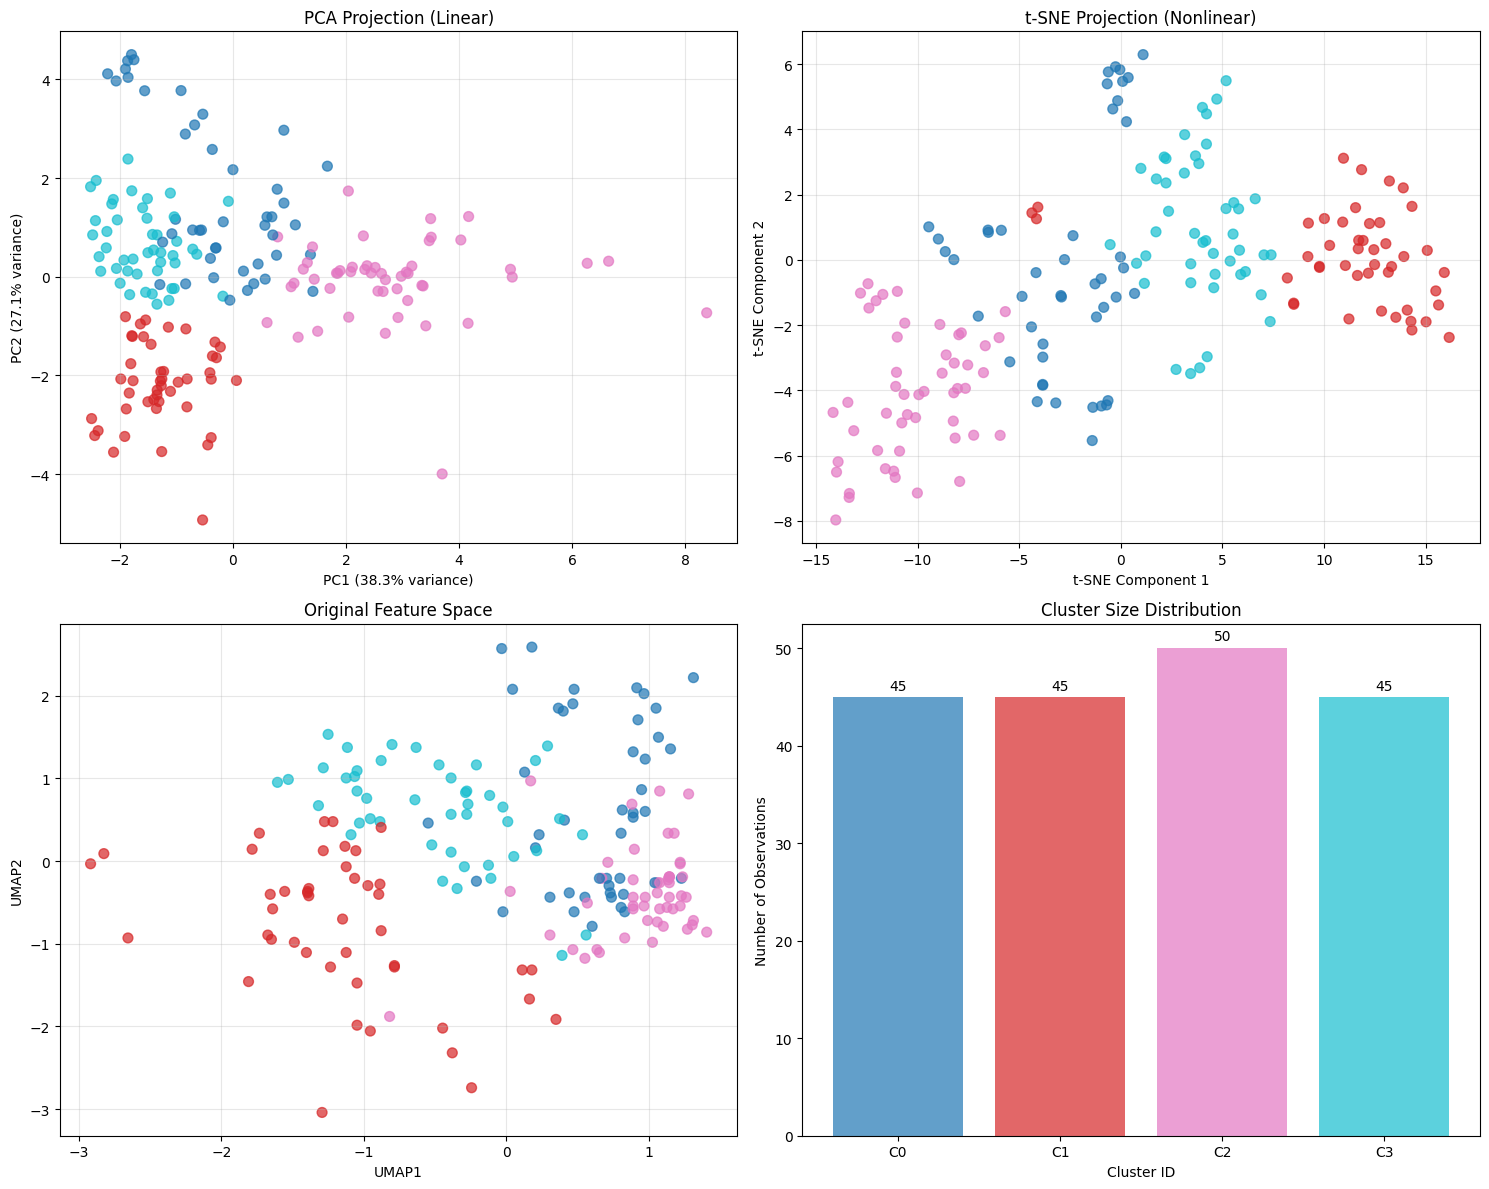


VISUALIZATION ANALYSIS:
-----------------------
PCA captures 65.4% of total variance in 2D
Assessment: ⚡ PCA provides moderate 2D representation
Mean cluster separation in PCA space: 3.50
Assessment: ✅ Well-separated clusters


{'pca_coords': array([[-2.47895097e+00,  8.49026977e-01],
        [-9.92093474e-01,  7.19331909e-01],
        [-1.33971544e+00,  8.48449354e-01],
        [-1.50186640e+00, -2.53265136e+00],
        [-2.95929862e-01,  5.85639523e-01],
        [ 1.83409581e+00,  7.43625941e-02],
        [-1.98129228e+00, -2.07072229e+00],
        [-1.27607464e+00,  2.96080174e-01],
        [-1.88477452e+00, -2.67801185e+00],
        [-1.57851151e+00, -1.21418741e+00],
        [-1.92569668e+00,  3.39403323e-01],
        [ 4.46871578e-01,  2.60147980e-01],
        [-2.06396592e+00,  3.96856839e+00],
        [ 1.67242003e+00,  2.24169585e+00],
        [ 2.11347854e+00,  1.94311348e-01],
        [-1.25547279e+00, -2.07064504e+00],
        [ 6.40779782e-02, -2.10076664e+00],
        [ 2.59526833e-01, -2.76405122e-01],
        [ 2.30859708e+00,  8.28951229e-01],
        [ 3.70252852e+00, -3.99525147e+00],
        [-3.60567665e-01, -1.60533637e+00],
        [-8.30192247e-01, -1.05615224e+00],
        [-2.043311

In [29]:
def cluster_visualization_overview(data, labels, feature_names=None):
    """Create comprehensive overview of cluster visualization approaches"""

    print("CLUSTER VISUALIZATION OVERVIEW")
    print("=" * 31)

    n_samples, n_features = data.shape
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    print(f"Dataset: {n_samples} observations, {n_features} features")
    print(f"Clusters: {n_clusters} discovered")

    # Create visualization comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA projection (linear)
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(data)

    ax1 = axes[0, 0]
    ax1.scatter(
        pca_coords[:, 0], pca_coords[:, 1], c=labels, cmap="tab10", alpha=0.7, s=50
    )
    ax1.set_title("PCA Projection (Linear)")
    ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    ax1.grid(True, alpha=0.3)

    # t-SNE projection (nonlinear) - only for reasonable dataset sizes
    if n_samples <= 2000:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, n_samples // 4))
        tsne_coords = tsne.fit_transform(data)

        ax2 = axes[0, 1]
        ax2.scatter(
            tsne_coords[:, 0],
            tsne_coords[:, 1],
            c=labels,
            cmap="tab10",
            alpha=0.7,
            s=50,
        )
        ax2.set_title("t-SNE Projection (Nonlinear)")
        ax2.set_xlabel("t-SNE Component 1")
        ax2.set_ylabel("t-SNE Component 2")
        ax2.grid(True, alpha=0.3)
    else:
        ax2 = axes[0, 1]
        ax2.text(
            0.5,
            0.5,
            f"Dataset too large\nfor t-SNE\n({n_samples} samples)\n\nConsider sampling\nor alternative methods",
            ha="center",
            va="center",
            transform=ax2.transAxes,
            fontsize=12,
        )
        ax2.set_title("t-SNE Projection (Not Applicable)")

    # Feature space visualization (first two features)
    ax3 = axes[1, 0]
    ax3.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab10", alpha=0.7, s=50)
    feature1_name = feature_names[0] if feature_names else "Feature 1"
    feature2_name = feature_names[1] if feature_names else "Feature 2"
    ax3.set_title("Original Feature Space")
    ax3.set_xlabel(feature1_name)
    ax3.set_ylabel(feature2_name)
    ax3.grid(True, alpha=0.3)

    # Cluster size distribution
    ax4 = axes[1, 1]
    unique_labels, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    bars = ax4.bar(range(len(unique_labels)), counts, color=colors, alpha=0.7)
    ax4.set_title("Cluster Size Distribution")
    ax4.set_xlabel("Cluster ID")
    ax4.set_ylabel("Number of Observations")
    ax4.set_xticks(range(len(unique_labels)))
    ax4.set_xticklabels([f"C{i}" if i != -1 else "Noise" for i in unique_labels])

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + count * 0.01,
            f"{count}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    # Analysis summary
    print(f"\nVISUALIZATION ANALYSIS:")
    print("-" * 23)

    # PCA analysis
    total_variance = sum(pca.explained_variance_ratio_[:2])
    print(f"PCA captures {total_variance:.1%} of total variance in 2D")

    if total_variance > 0.7:
        pca_assessment = "✅ PCA provides good 2D representation"
    elif total_variance > 0.5:
        pca_assessment = "⚡ PCA provides moderate 2D representation"
    else:
        pca_assessment = "⚠️ PCA may miss important structure in 2D"

    print(f"Assessment: {pca_assessment}")

    # Cluster separation assessment
    if n_clusters > 1:
        # Simple separation metric using PCA coordinates
        cluster_centers = []
        for cluster_id in set(labels):
            if cluster_id != -1:
                cluster_mask = labels == cluster_id
                center = np.mean(pca_coords[cluster_mask], axis=0)
                cluster_centers.append(center)

        if len(cluster_centers) > 1:
            from scipy.spatial.distance import pdist

            center_distances = pdist(cluster_centers)
            mean_separation = np.mean(center_distances)

            print(f"Mean cluster separation in PCA space: {mean_separation:.2f}")

            if mean_separation > 2:
                separation_assessment = "✅ Well-separated clusters"
            elif mean_separation > 1:
                separation_assessment = "⚡ Moderately separated clusters"
            else:
                separation_assessment = (
                    "⚠️ Overlapping clusters - consider other methods"
                )

            print(f"Assessment: {separation_assessment}")

    return {
        "pca_coords": pca_coords,
        "pca_variance_explained": pca.explained_variance_ratio_,
        "total_variance_2d": total_variance,
    }


cluster_visualization_overview(
    df_standard_scaled.values, labels["KMeans"], feature_names=df.columns.tolist()
)

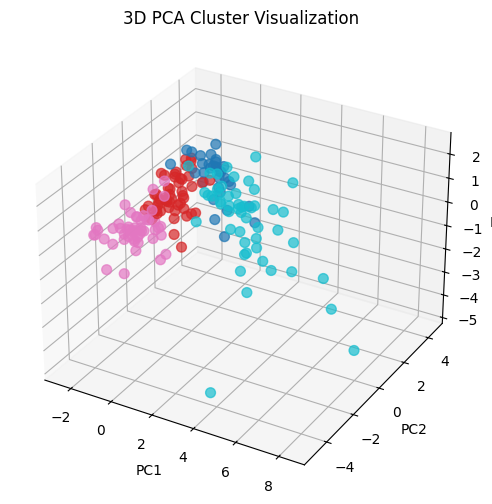

In [41]:
def plot_3d_pca(data, labels):
    pca = PCA(n_components=3)
    coords = pca.fit_transform(data)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        coords[:, 0],
        coords[:, 1],
        coords[:, 2],
        c=labels,
        cmap="tab10",
        s=50,
        alpha=0.7,
    )
    ax.set_title("3D PCA Cluster Visualization")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.show()


plot_3d_pca(df_standard_scaled, labels["Hierarchical"])

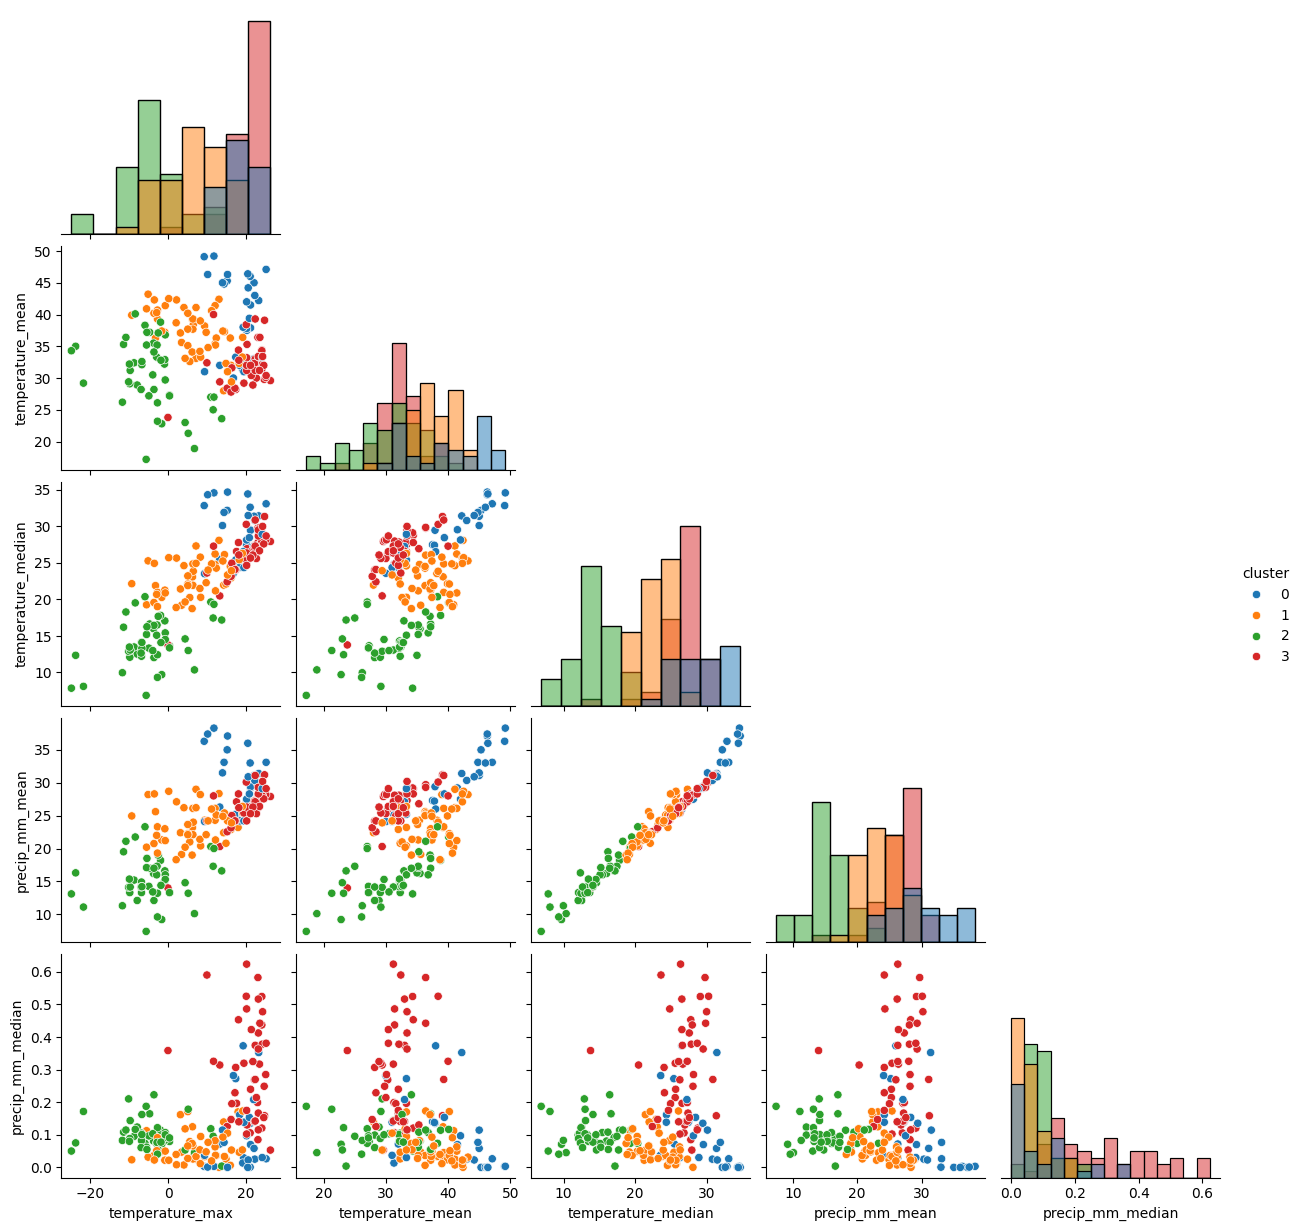

In [42]:
def pairwise_scatter_matrix(data, labels, feature_names):
    # Handle both DataFrame and numpy array input
    if isinstance(data, pd.DataFrame):
        df_plot = data.iloc[:, :6].copy()
        df_plot.columns = feature_names[:6]
    else:
        df_plot = pd.DataFrame(data[:, :6], columns=feature_names[:6])
    df_plot["cluster"] = labels
    sns.pairplot(df_plot, hue="cluster", palette="tab10", corner=True, diag_kind="hist")
    plt.show()


pairwise_scatter_matrix(df_unscaled, labels["Hierarchical"], df_standard_scaled.columns)